# ECE449 Small project

In [1]:
import torch
import torchvision
from PIL import Image
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.checkpoint import checkpoint
import torch.nn.functional as F
from torch.optim import Adam
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import random
import pandoc

## Custimized Dataset

First we define two functions: __init_process__ and __Myloader__, init_process zip path and label to the data list. And Myloader use Image.open from pillow to read our image

In [2]:
def init_process(path, lens, label):
    data = []
    name = label-1
    for i in range(lens[0], lens[1]):
        data.append([path % i, name])
    return data
def Myloader(path):
    return Image.open(path)

In [3]:
class MyData(Dataset):

    def __init__(self, data, transform, loader):
        self.data = data
        self.transfrom = transform
        self.loader = loader

    def __getitem__(self, item):
        img, label = self.data[item]
        img = self.loader(img)
        img = self.transfrom(img)
        return img, label

    def __len__(self):
        return len(self.data)

For dataset, we define basic __init__, __getitem__ and __len__. In the __init__ of class, we have three input: **data** is a list contain path and label to the image, tranform is a transform function which normalize out image and put it to Tensor. loader is function to read image from our path. So for our __getitem__ function, we first obtain the img path and label from data list, and put image to the tensor.

In [4]:
def load_data():
    transform = transforms.Compose([
        transforms.CenterCrop(128),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307), std=(0.3081))
    ])
    train_data = []
    test_data = []
    for i in range(1,21):
        if i<10:
            path = 'coil-20-proc/0%d'%(i)+'/obj%d'%(i)+'__%d.png'
            train_data += init_process(path, [0, 60], i)
            test_data += init_process(path, [60, 72], i)
        else:
            path = 'coil-20-proc/%d'%(i)+'/obj%d'%(i)+'__%d.png'
            train_data += init_process(path, [0, 60], i)
            test_data += init_process(path, [60, 72], i)

    train = MyData(train_data, transform=transform, loader=Myloader)
    test = MyData(test_data, transform=transform, loader=Myloader)
    train_data = DataLoader(dataset=train, batch_size=batch_size, shuffle=True, num_workers=0)
    test_data = DataLoader(dataset=test, batch_size=batch_size, shuffle=True, num_workers=0)
    return train_data, test_data

Then we define load_ddata function, split our dataset [0-60] as train dataset and [60, 72] as test dataset, and use torch Dataloader with batch_size = 10

## Network
We use Resnet to build our classifier. This is a basic block with 64 channel in our Net

![avatar](basicblock.png)

First of all, we define a __BN_Conv2d__ which means combine Convolution with Normalization and RELU

In [5]:
class BN_Conv2d(nn.Module):
    """
    BN_CONV, default activation is ReLU
    """

    def __init__(self, in_channels: object, out_channels: object, kernel_size: object, stride: object, padding: object,
                 dilation=1, groups=1, bias=False, activation=True) -> object:
        super(BN_Conv2d, self).__init__()
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,
                            padding=padding, dilation=dilation, groups=groups, bias=bias),
                  nn.BatchNorm2d(out_channels)]
        if activation:
            layers.append(nn.ReLU(inplace=True))
        self.seq = nn.Sequential(*layers)

    def forward(self, x):
        return self.seq(x)

Then define our Basic Block

In [6]:
class BasicBlock(nn.Module):
    """
    basic building block for ResNet-18
    """
    message = "basic"

    def __init__(self, in_channels, out_channels, strides):
        super(BasicBlock, self).__init__()
        self.conv1 = BN_Conv2d(in_channels, out_channels, 3, stride=strides, padding=1, bias=False)  # same padding
        self.conv2 = BN_Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False, activation=False)

        # fit input with residual output
        self.short_cut = nn.Sequential()
        if strides != 1:
            self.short_cut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=strides, padding=0, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out + self.short_cut(x)
        return F.relu(out)

In [7]:
class Net(nn.Module):
    def __init__(self, block: object, groups: object, num_classes=1000) -> object:
        super(Net, self).__init__()
        self.channels = 64  # out channels from the first convolutional layer
        self.block = block

        self.conv1 = nn.Conv2d(1, self.channels, 128, stride=2, padding=3, bias=False)
        self.bn = nn.BatchNorm2d(self.channels)
        self.pool1 = nn.MaxPool2d(3, 2, 1)
        self.conv2_x = self._make_conv_x(channels=64, blocks=groups[0], strides=1, index=2)
        self.conv3_x = self._make_conv_x(channels=128, blocks=groups[1], strides=2, index=3)
        self.conv4_x = self._make_conv_x(channels=256, blocks=groups[2], strides=2, index=4)
        self.conv5_x = self._make_conv_x(channels=512, blocks=groups[3], strides=2, index=5)
        self.pool2 = nn.AvgPool2d(8)
        patches = 512 if self.block.message == "basic" else 512 * 4
        self.fc = nn.Linear(patches, num_classes)  # for 224 * 224 input size


    def _make_conv_x(self, channels, blocks, strides, index):
        """
        making convolutional group
        :param channels: output channels of the conv-group
        :param blocks: number of blocks in the conv-group
        :param strides: strides
        :return: conv-group
        """
        list_strides = [strides] + [1] * (blocks - 1)  # In conv_x groups, the first strides is 2, the others are ones.
        conv_x = nn.Sequential()
        for i in range(len(list_strides)):
            layer_name = str("block_%d_%d" % (index, i))  # when use add_module, the name should be difference.
            conv_x.add_module(layer_name, self.block(self.channels, channels, list_strides[i]))
            self.channels = channels if self.block.message == "basic" else channels * 4
        return conv_x


    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(self.bn(out))
        out = self.pool1(out)
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)
        #out = self.pool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [8]:
def ResNet_18(num_classes=20):
    return Net(block=BasicBlock, groups=[2, 2, 2, 2], num_classes=num_classes)

Define and loss function use CrossEntropyLoss and use Adam Optimizer

In [9]:
Cuda = True
batch_size = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
train_data, test_data = load_data()
model = ResNet_18().cuda()
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

Start our train

In [10]:
def saveModel():
    path = "./Model.pth"
    torch.save(model.state_dict(), path)

#Function to test the model with the test dataset and print the accuracy for the test image
def testAccuracy():
    model.eval()
    accuracy = 0.0
    total = 0.0
    for data in test_data:
        images, labels = data
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()
    accuracy = (100 * accuracy) / total
    return accuracy

def train(num_epochs):

    best_loss = 100.0
    count = 0
    loss_list = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_data, 0):

            #get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            running_loss += loss.detach().item()

        print('For epoch %d loss: %.3f' % (epoch+1, running_loss / 1000))
        # zero the loss
        loss_list.append(running_loss)
        running_loss = 0.0
        if(running_loss < best_loss):
            best_loss = running_loss

        count += 1
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        saveModel()
    loss_list = np.array(loss_list)
    return loss_list


In [11]:
loss = train(30)


For epoch 1 loss: 0.107
For epoch 1 the test accuracy over the whole test set is 60 %
For epoch 2 loss: 0.059
For epoch 2 the test accuracy over the whole test set is 80 %
For epoch 3 loss: 0.038
For epoch 3 the test accuracy over the whole test set is 75 %
For epoch 4 loss: 0.032
For epoch 4 the test accuracy over the whole test set is 83 %
For epoch 5 loss: 0.024
For epoch 5 the test accuracy over the whole test set is 84 %
For epoch 6 loss: 0.024
For epoch 6 the test accuracy over the whole test set is 80 %
For epoch 7 loss: 0.040
For epoch 7 the test accuracy over the whole test set is 88 %
For epoch 8 loss: 0.013
For epoch 8 the test accuracy over the whole test set is 97 %
For epoch 9 loss: 0.026
For epoch 9 the test accuracy over the whole test set is 77 %
For epoch 10 loss: 0.015
For epoch 10 the test accuracy over the whole test set is 78 %
For epoch 11 loss: 0.015
For epoch 11 the test accuracy over the whole test set is 82 %
For epoch 12 loss: 0.010
For epoch 12 the test acc

Text(0.5, 1.0, 'Loss vs Epoch')

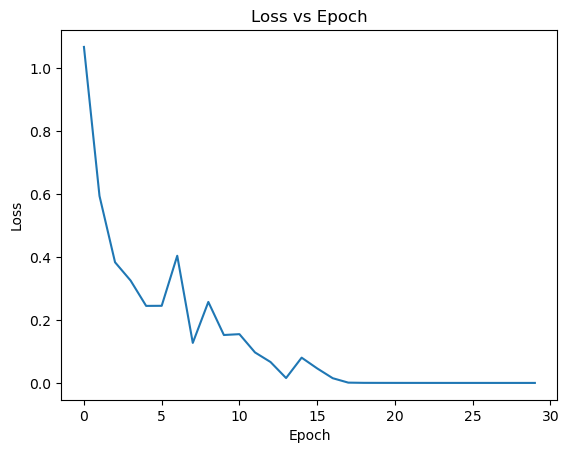

In [16]:
plt.plot(np.arange(30), loss/100)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')


## Predict in Test dataset

In [13]:
def imageshow(img):
    img = img * 0.3081 + 0.1307     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def testBatch():
    batch_size = 20
    # get batch of images from the test DataLoader
    images, labels = next(iter(test_data))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))

    # Show the real labels on the screen
    print('Real labels: ', ' '.join('%5s' % str(labels[j].numpy()+1)
                               for j in range(batch_size)))

    # Let's see what if the model identifiers the  labels of those example
    images = Variable(images.to(device))
    labels = Variable(labels.to(device))
    outputs = model(images).cuda()

    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)

    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % str(predicted[j].cpu().numpy()+1)
                              for j in range(batch_size)))

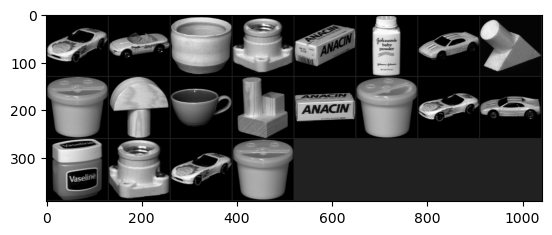

Real labels:      6    19    17    14     5     8     3     2    15    11    18     7     5    15     6     3    10    14     6    15
Predicted:      6    19    17    14     5     8     3     2    15    11    18     7     5    15     6     3    10    14     6    15


In [14]:


# Test with batch of images
testBatch()